### Params for transformations

In [1]:
paa_window_size = 5

sax_alphabet_size = 9

one_d_sax_alphabet_size_avg = 9
one_d_sax_alphabet_size_slope = 3

a_sax_alphabet_size = 9
k_means_eval_min_alphabet_size = 2
k_means_eval_max_alphabet_size = 10

e_sax_alphabet_size = 9

persist_alphabet_size = 9
persist_min_alphabet_size = 2
persist_max_alphabet_size = 9
persist_skip = 4

### Load data
.parquet-files can be loaded

either whole directory or single file into list consisting of dataframes with one column (i.e. time series) each

In [2]:
from utils import load_parquet_to_df_list


path = "../../../0_data/synth_pattern_data_for_synth_drive_generation"
df_list = load_parquet_to_df_list(path)

# do not use metadata of time series
df_orig = [df["dim_0"].to_frame() for df in df_list]

In [3]:
df_orig[0]

,dim_0
0,70.902463
1,70.282942
2,68.703804
3,64.193219
4,60.321183
...,...
896,79.357289
897,88.933892
898,83.036114
899,85.052833


### Z-normalize data

In [4]:
from utils import z_normalize


# additionally cut of some time series for a shorter representation
df_norm = [z_normalize(df) for df in df_orig[:3]]
num_dfs = len(df_norm)

In [5]:
df_norm[0]

,dim_0
0,0.316689
1,0.281520
2,0.191878
3,-0.064174
4,-0.283977
...,...
896,0.796642
897,1.340275
898,1.005477
899,1.119960


### PAA transformation

In [6]:
from approximation.paa import PAA


paa = PAA(paa_window_size)
df_paa = [paa.transform(df) for df in df_norm]

In [7]:
df_paa[0]

,dim_0
0,0.088387
1,0.057589
2,1.073152
3,1.502742
4,1.137425
...,...
175,-0.338246
176,-0.391852
177,-0.660236
178,-0.129728


### PAA inverse transformation

In [8]:
df_paa_inv = [paa.inv_transform(df, ts_size=df_norm[idx].shape[0]) for idx, df in enumerate(df_paa)]

In [9]:
df_paa_inv[0]

,dim_0
0,0.088387
1,0.088387
2,0.088387
3,0.088387
4,0.088387
...,...
896,0.711437
897,0.711437
898,0.711437
899,0.711437


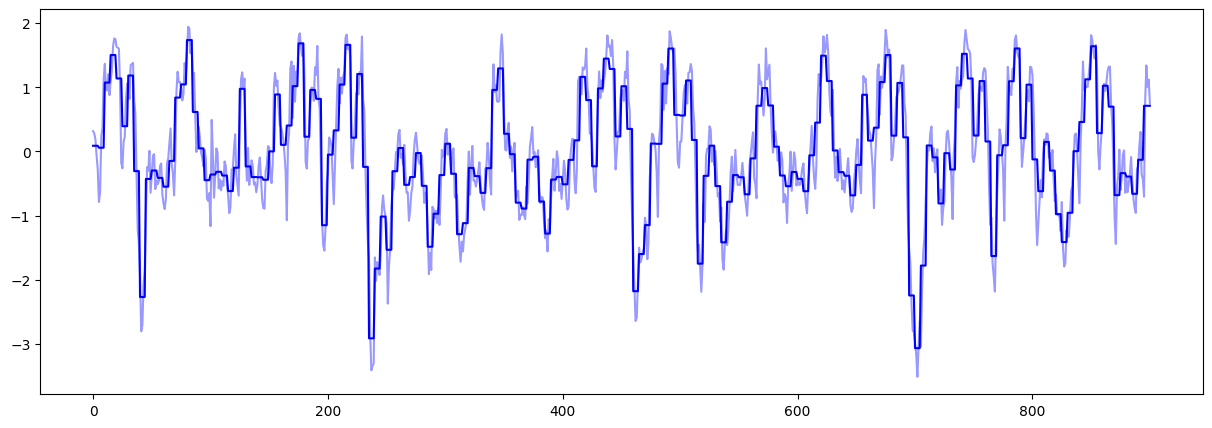

In [10]:
import matplotlib.pyplot as plt


def plot(df_ts):
    plt.figure(figsize=(15,5))
    plt.plot(df_norm[0], "b-", alpha=0.4)
    plt.plot(df_ts, "b-")
    plt.show()


plot(df_paa_inv[0])

### SAX transformation

In [11]:
from discretization.sax.sax import SAX


sax = SAX(sax_alphabet_size)
df_sax = [sax.transform(df) for df in df_paa]

In [12]:
df_sax[0]

,dim_0
0,e
1,e
2,h
3,i
4,h
...,...
175,d
176,d
177,c
178,e


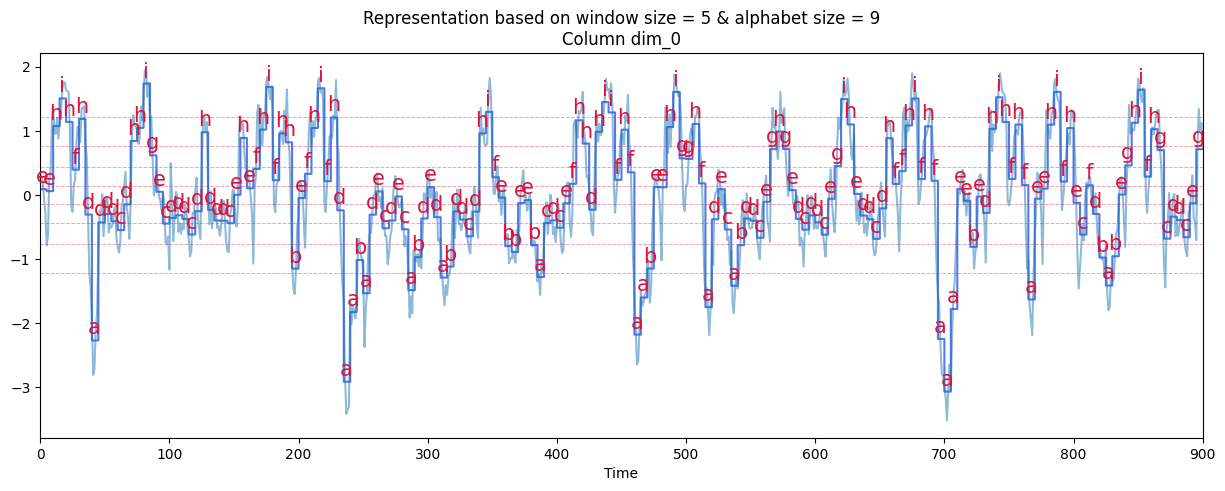

In [13]:
from discretization.sax.graphics import plot_paa_sax_symbols


# PAA representation with respective SAX symbols of intervals
plot_paa_sax_symbols(df_norm[0], df_paa[0], df_sax[0], sax.breakpoints, sax.alphabet_size, paa.window_size, num_column=0)

### SAX inverse transformation
diffrent symbol mapping strategies

In [14]:
from discretization.symbol_mapping import IntervalNormMedian, IntervalMean, MeanValuePoints, MedianValuePoints


# standard normal distribution is stretched across y-axix, median of each interval is taken
# symbol_mapping = [IntervalNormMedian(alphabet_size=sax.alphabet_size) for i in range(num_dfs)]

# mean of each interval is taken, bound is needed for most left and most right intervals, otherwise no bounds
# bound = sax.breakpoints[0] * 1.5 # edge breakpoints times offset
# bound = [max(abs(df_norm[idx].to_numpy().max()), abs(df_norm[idx].to_numpy().min())) for idx in range(num_dfs)]
# symbol_mapping = [IntervalMean(bound=bound[idx]) for idx in range(len(bound))]

# mean of original (normalized) points within each interval is taken
# symbol_mapping = [MeanValuePoints(df_norm[idx]) for idx in range(num_dfs)]

# median of original (normalized) points within each interval is taken
symbol_mapping = [MedianValuePoints(df_norm[idx]) for idx in range(num_dfs)]


# even different symbol mapping strategies within a dataframe list are possible
# half = num_dfs // 2
# symbol_mapping = [MeanValuePoints(df_norm[idx]) for idx in range(len(df_norm[:half]))] + [MedianValuePoints(df_norm[idx]) for idx in range(len(df_norm[half:]))]


# inverse SAX transformation depends on symbol mapping strategy
df_sax_inv = [sax.inv_transform(df_sax[idx], ts_size=df_norm[idx].shape[0], window_size=paa.window_size, symbol_mapping=symbol_mapping[idx]) for idx in range(num_dfs)]

In [15]:
df_sax_inv[0]

,dim_0
0,-0.008981
1,-0.008981
2,-0.008981
3,-0.008981
4,-0.008981
...,...
896,0.630213
897,0.630213
898,0.630213
899,0.630213


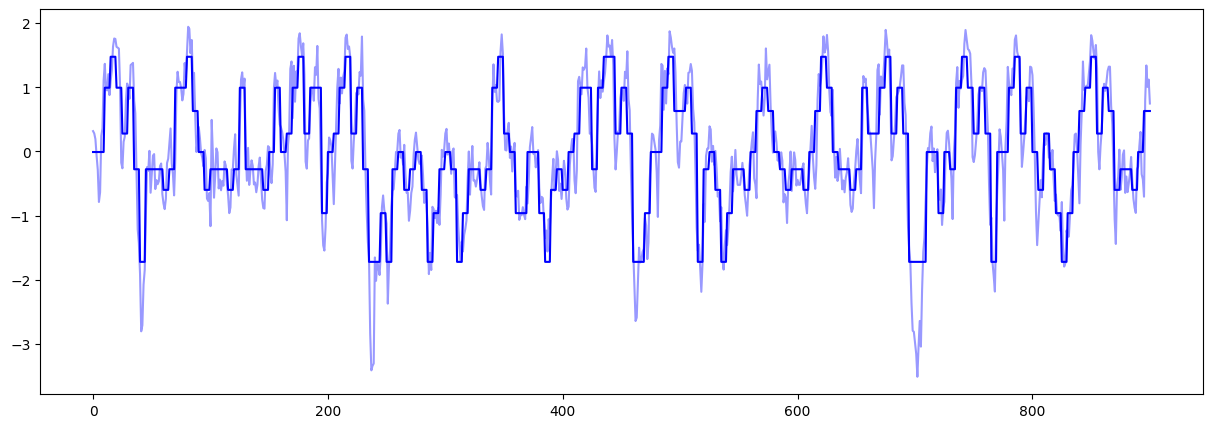

In [16]:
plot(df_sax_inv[0])

### SAX distance ("MINDIST")
only defined for equal length time series

### 1d-SAX transformation
symbols are not interleaved as in paper

first symbol is quantized segment average

second symbol is quantized segment slope

In [17]:
from discretization.sax.one_d_sax import OneDSAX


one_d_sax = OneDSAX(one_d_sax_alphabet_size_avg, one_d_sax_alphabet_size_slope)
df_one_d_sax = [one_d_sax.transform(df_paa[idx], df_norm[idx], paa.window_size) for idx in range(num_dfs)]

In [18]:
df_one_d_sax[0]

,dim_0
0,ea
1,ec
2,ha
3,ic
4,ha
...,...
175,dc
176,dc
177,cb
178,ea


### 1d-SAX inverse transformation

symbols for segment average and segment slope are separateley inverse transformed

different symbol mapping strategies for segment average and segment slope are possible

function to inverse transform depends on timestamp of a point (t_point): symbol_value_avg + symbol_value_slope * (t_point - t_segment_middle)

In [19]:
symbol_mapping_avg = [IntervalNormMedian(alphabet_size=one_d_sax.alphabet_size_avg) for i in range(num_dfs)]


# make sure to use the slope values for the symbol mapping strategies that depend on the original (normalized) data
# slope values can be computed separately
from discretization.sax.one_d_sax import compute_slopes
df_slopes = [compute_slopes(df_norm[idx], paa.window_size) for idx in range(num_dfs)]
symbol_mapping_slope = [MeanValuePoints(df_slopes[idx]) for idx in range(len(df_slopes))]

# make sure to use the right alphabet size and the right variance for the assumend Gaussian distribution
# symbol_mapping_slope = [IntervalNormMedian(alphabet_size=one_d_sax.alphabet_size_slope, one_d_sax.var_slope) for idx in range(num_dfs)]

# import warnings
# warnings.filterwarnings('ignore')
df_one_d_sax_inv = [one_d_sax.inv_transform(df_norm[idx], df_one_d_sax[idx], paa.window_size, symbol_mapping_avg[idx], symbol_mapping_slope[idx])
                    for idx in range(num_dfs)]

c:\users\danie\documents\karlsruhe\03_kit_studium\07_semester\bachelorarbeit\bachelorarbeit\repo\implementation\1_code\src\discretization\sax\one_d_sax.py:202: UserWarning: Make sure you used the segment slopes for initializing the chosen 'symbol_mapping_slope' strategy. Otherwise, the results might not be meaningful.
  warnings.warn("Make sure you used the segment slopes for "
c:\users\danie\documents\karlsruhe\03_kit_studium\07_semester\bachelorarbeit\bachelorarbeit\repo\implementation\1_code\src\discretization\sax\one_d_sax.py:202: UserWarning: Make sure you used the segment slopes for initializing the chosen 'symbol_mapping_slope' strategy. Otherwise, the results might not be meaningful.
  warnings.warn("Make sure you used the segment slopes for "
c:\users\danie\documents\karlsruhe\03_kit_studium\07_semester\bachelorarbeit\bachelorarbeit\repo\implementation\1_code\src\discretization\sax\one_d_sax.py:202: UserWarning: Make sure you used the segment slopes for initializing the chosen

In [20]:
df_one_d_sax_inv[0]

,dim_0
0,0.436129
1,0.218065
2,0.0
3,-0.218065
4,-0.436129
...,...
896,0.388401
897,0.589456
898,0.790511
899,0.991566


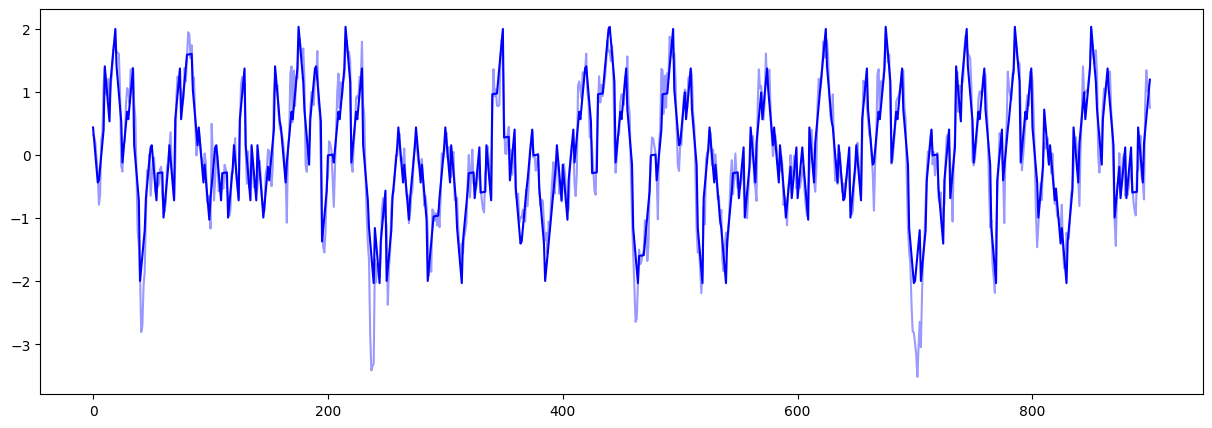

In [21]:
plot(df_one_d_sax_inv[0])

### Adaptive SAX transformation

In [22]:
from discretization.sax.adaptive_sax import AdaptiveSAX


a_sax = AdaptiveSAX(alphabet_size=a_sax_alphabet_size)

# outputs aSAX transformation as well as the individual breakpoints that were used for this transformation (as a tuple)
# individual breakpoints are needed for inverse transformation
df_a_sax_breakpoints = [a_sax.transform(df_paa[idx]) for idx in range(num_dfs)]

In [23]:
df_a_sax_breakpoints[0][0]

,dim_0
0,e
1,e
2,h
3,i
4,h
...,...
175,d
176,d
177,c
178,e


In [24]:
import pandas as pd


# different breakpoints for each time series
pd.concat([df_a_sax_breakpoints[idx][1] for idx in range(len(df_a_sax_breakpoints[:3]))], axis=1)

,dim_0,dim_0,dim_0
0,-1.996080,-1.217609,-1.026164
1,-1.116669,-0.858704,-0.812513
2,-0.573699,-0.535836,-0.531073
3,-0.188174,-0.159965,-0.234239
4,0.134599,0.218430,0.134348
5,0.503931,0.536396,0.543008
6,0.908069,0.981790,1.051647
7,1.331605,1.454713,1.602108


### Adaptive SAX inverse transformation

In [25]:
symbol_mapping = [MeanValuePoints(df_norm[idx]) for idx in range(num_dfs)]


df_a_sax_inv = [a_sax.inv_transform(df_a_sax_breakpoints[idx][0], df_norm[idx].shape[0], paa.window_size, symbol_mapping[idx], df_a_sax_breakpoints[idx][1])
                for idx in range(num_dfs)]

In [26]:
df_a_sax_inv[0]

,dim_0
0,-0.033797
1,-0.033797
2,-0.033797
3,-0.033797
4,-0.033797
...,...
896,0.743376
897,0.743376
898,0.743376
899,0.743376


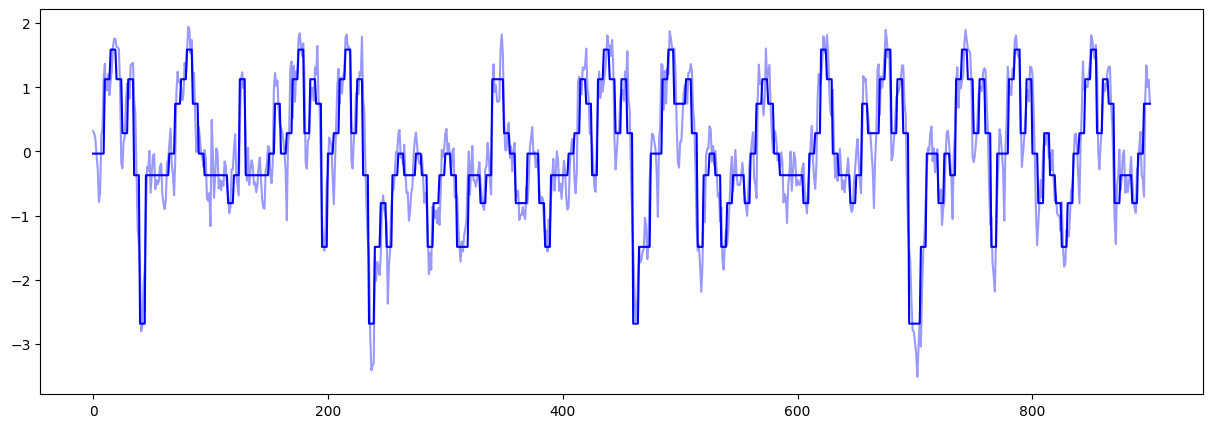

In [27]:
plot(df_a_sax_inv[0])

### Evaluation of k-means of Adaptive SAX

find the most appropriate alphabet size according to internal evaluation metrics

supports parameter-free usage of Adaptive SAX given a fixed window size for the preprocessed PAA transformation

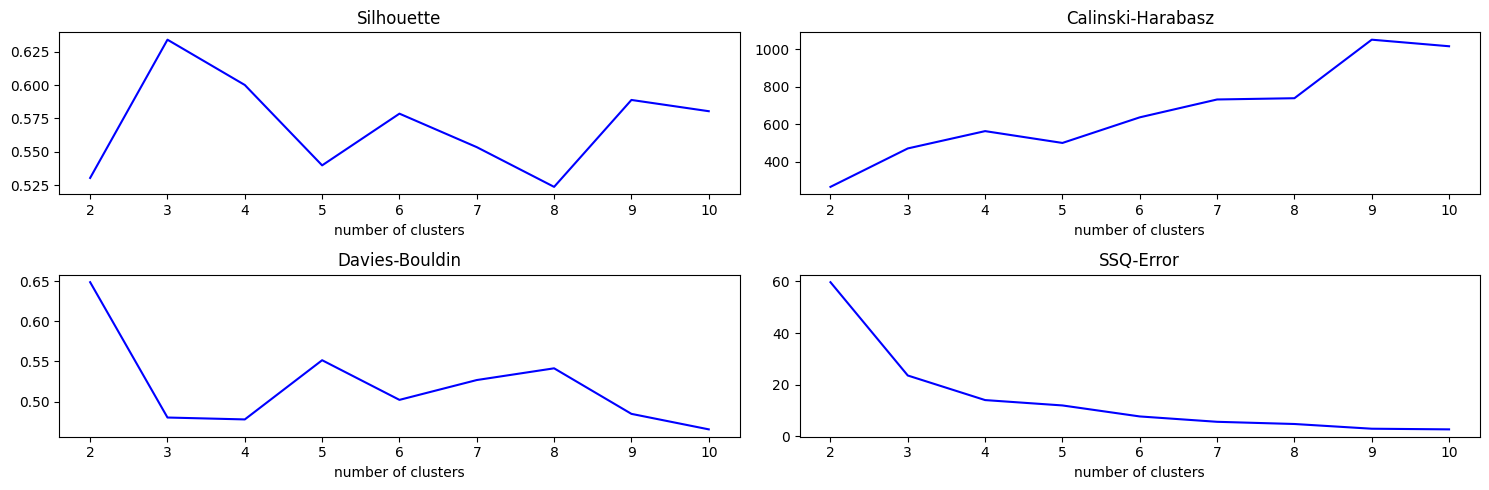

In [28]:
from discretization.sax.adaptive_sax import eval_k_means
from graphics import plot_internal_clustering_metrics


# good clustering in this case seems to be achieved with an alphabet size of x
eval_metrics = eval_k_means(df_paa[0], k_means_eval_min_alphabet_size, k_means_eval_max_alphabet_size)

# which time series to choose within a dataframe
ts = 0

# choose right 1d-array within returned 3d-array
pos_ssq_error = 0
pos_silhouette = 1
pos_calinski_harabasz = 2
pos_davies_bouldin = 3

# decompose np.array of shape (num_ts, 4 (#internal evaluation metrics), num_diff_alphabet_sizes)
ssq_error = eval_metrics[ts][pos_ssq_error]
silhouette = eval_metrics[ts][pos_silhouette]
calinski_harabasz = eval_metrics[ts][pos_calinski_harabasz]
davies_bouldin = eval_metrics[ts][pos_davies_bouldin]

plot_internal_clustering_metrics(silhouette, calinski_harabasz, davies_bouldin, k_means_eval_min_alphabet_size, ssq_error)

### Extended SAX transformation

In [29]:
from discretization.sax.extended_sax import ExtendedSAX


e_sax = ExtendedSAX(e_sax_alphabet_size)

# each transformation outputs a 4-tuple (df_e_sax, df_sax_mean, df_sax_max, df_sax_min)
# the last three are needed for inverse transformation
df_e_sax = [e_sax.transform(df_paa[idx], df_norm[idx], paa.window_size) for idx in range(num_dfs)]

In [30]:
df_e_sax[0][0]

,0
0,fed
1,beh
2,ihh
3,hii
4,ihd
...,...
175,dec
176,cde
177,cbd
178,efc


### Extended SAX inverse transformation

In [31]:
symbol_mapping = [MeanValuePoints(df_norm[idx]) for idx in range(num_dfs)]

df_e_sax_inv = [e_sax.inv_transform(df_e_sax[idx][1], df_e_sax[idx][2], df_e_sax[idx][3], df_norm[idx].shape[0], paa.window_size, symbol_mapping[idx])
                for idx in range(num_dfs)]

In [32]:
df_e_sax_inv[0]

,0
0,0.275721
1,-0.009251
2,-0.009251
3,-0.009251
4,-0.279035
...,...
896,0.622539
897,1.490807
898,0.622539
899,0.622539


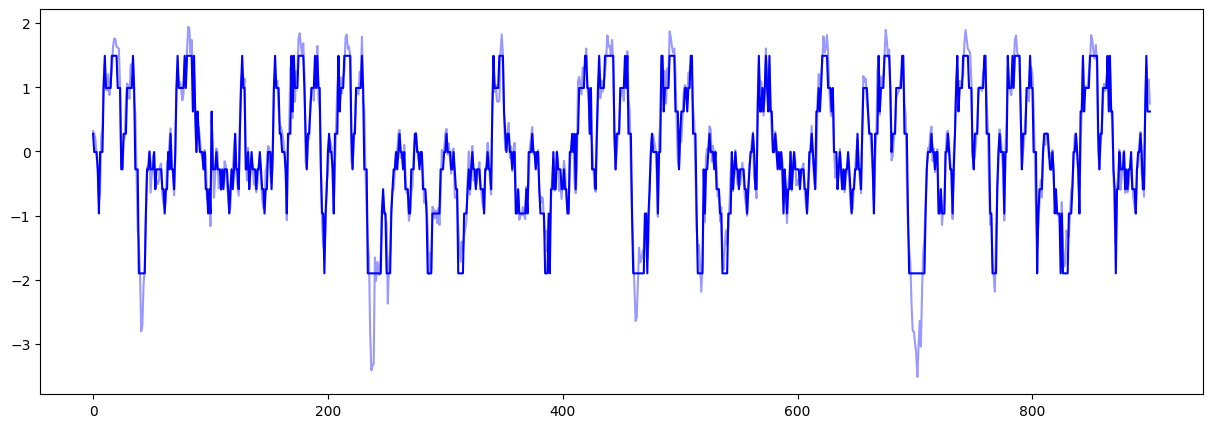

In [33]:
plot(df_e_sax_inv[0])

### Persist transformation

In [34]:
from discretization.persist.persist import Persist


persist = Persist(persist_alphabet_size)

# each transformation outputs a 3-tuple (df_persist, alphabets, breakpoints), because all are needed for inverse transformation
df_persist = [persist.transform(df_paa[idx], df_norm[idx]) for idx in range(num_dfs)]

In [35]:
df_persist[0][0]

,0
0,f
1,f
2,h
3,i
4,h
...,...
175,f
176,e
177,d
178,f


### Persist inverse transformation

In [36]:
symbol_mapping = [MeanValuePoints(df_norm[idx]) for idx in range(num_dfs)]

df_persist_inv = [persist.inv_transform(df_persist[idx][0], df_norm[idx].shape[0], paa.window_size, symbol_mapping[idx], df_persist[idx][1], df_persist[idx][2])
                  for idx in range(num_dfs)]

In [37]:
df_persist_inv[0].iloc[:20]

,0
0,-0.113723
1,-0.113723
2,-0.113723
3,-0.113723
4,-0.113723
5,-0.113723
6,-0.113723
7,-0.113723
8,-0.113723
9,-0.113723


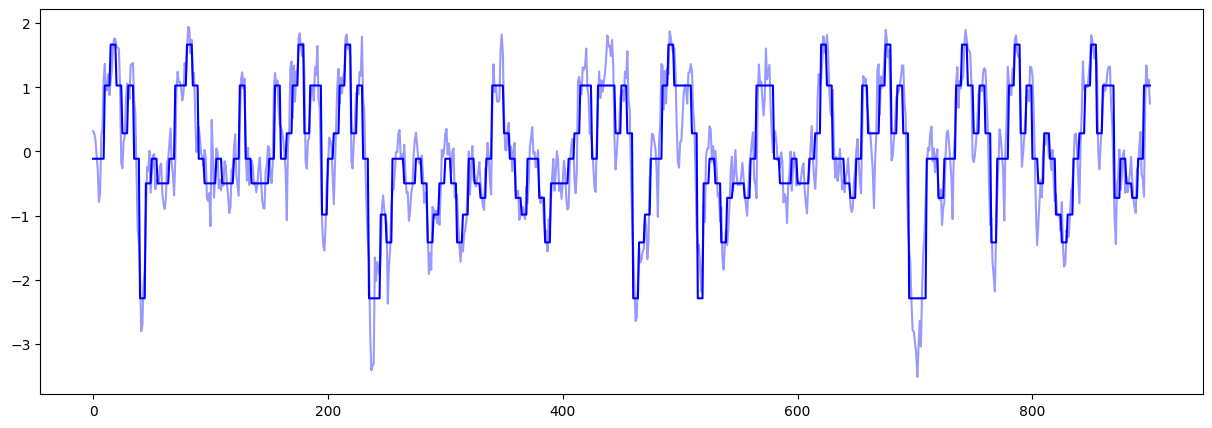

In [38]:
plot(df_persist_inv[0])

### Compare all transformations

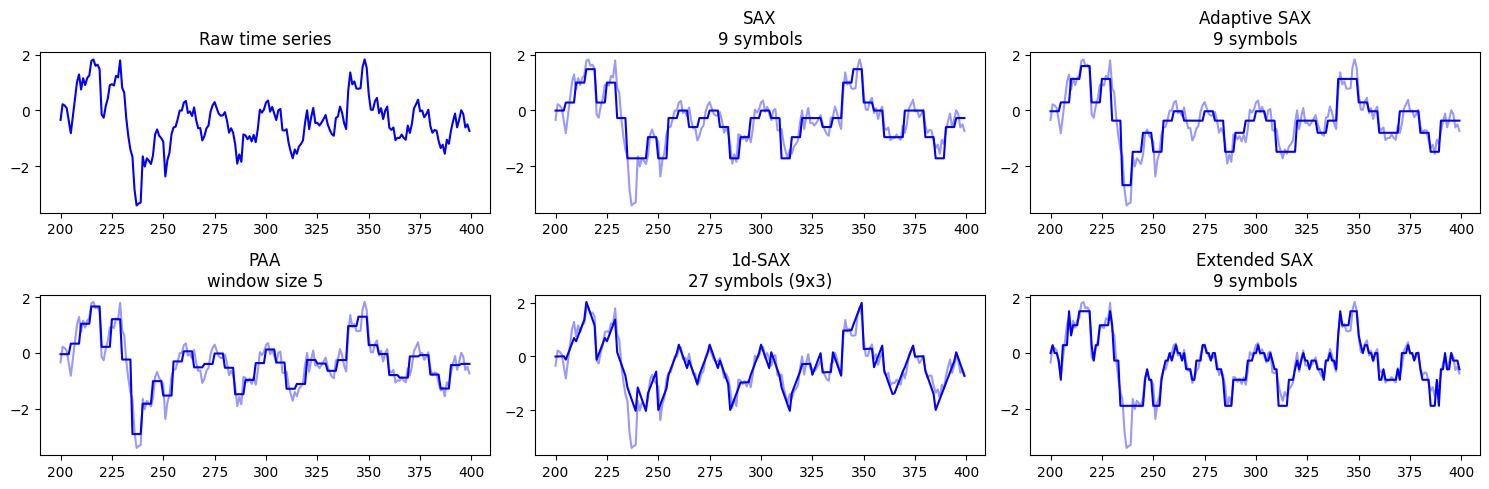

In [39]:
from discretization.sax.graphics import plot_sax_variants

cutout = range(200,400)
plot_sax_variants(df_norm[0].iloc[cutout], df_paa_inv[0].iloc[cutout], df_sax_inv[0].iloc[cutout], df_a_sax_inv[0].iloc[cutout],
                  df_one_d_sax_inv[0].iloc[cutout], df_e_sax_inv[0].iloc[cutout], paa.window_size, sax.alphabet_size, a_sax.alphabet_size,
                  one_d_sax.alphabet_size_avg, one_d_sax.alphabet_size_slope, e_sax.alphabet_size, num_column=0)

### Point-to-Point Metrics
21 point-to-point metrics (but a lot of small variations)

In [40]:
from utils import get_metric_instance
from pp_metrics.pp_metrics import PP_METRICS_MODULE


pp_metrics = ["MeanAbsoluteError", "MeanSquaredError", "RootMeanSquaredError", "MedianAbsoluteError", "MedianSquaredError", "RootMedianSquaredError",
              "GeometricMeanAbsoluteError", "GeometricMeanSquaredError", "RootGeometricMeanSquaredError", "MeanAbsolutePercentageError",
              "SymmetricMeanAbsolutePercentageError", "MedianAbsolutePercentageError", "SymmetricMedianAbsolutePercentageError", "MeanSquaredPercentageError",
              "RootMeanSquaredPercentageError", "SymmetricMeanSquaredPercentageError", "RootSymmetricMeanSquaredPercentageError", "MedianSquaredPercentageError",
              "RootMedianSquaredPercentageError", "SymmetricMedianSquaredPercentageError", "RootSymmetricMedianSquaredPercentageError"]

# load metric instances
pp_metric_instances = [get_metric_instance(PP_METRICS_MODULE, metric) for metric in pp_metrics]

### Compute reconstruction error matrix
here for the first time series of the used time series dataset

In [41]:
# compute average over all time series of used dataset with another for-loop over each dataframe (i.e. time series) in the datframe list

results = []

for metric in pp_metric_instances:
    sax_inv = metric.compute(df_norm[0], df_sax_inv[0])
    sax_inv.name = "SAX"
    
    a_sax_inv = metric.compute(df_norm[0], df_a_sax_inv[0])
    a_sax_inv.name = "aSAX"
    
    one_d_sax_inv = metric.compute(df_norm[0], df_one_d_sax_inv[0])
    one_d_sax_inv.name = "1d-SAX"
    
    e_sax_inv = metric.compute(df_norm[0], df_e_sax_inv[0])
    e_sax_inv.name = "eSAX"
    
    persist_inv = metric.compute(df_norm[0], df_persist_inv[0])
    persist_inv.name = "Persist"
    
    df_results = pd.concat([sax_inv, a_sax_inv, one_d_sax_inv, e_sax_inv, persist_inv], axis=1)
    df_results.rename(index={0: metric.abbreviation}, inplace=True)
    results.append(df_results)

In [42]:
df = pd.concat(results)
df.style.highlight_max(color='orangered', axis=1).highlight_min(color="lightgreen", axis=1)

,SAX,aSAX,1d-SAX,eSAX,Persist
MAE,0.335746,0.326822,0.262702,0.195999,0.335327
MSE,0.206213,0.188397,0.132567,0.081470,0.200135
RMSE,0.454106,0.434048,0.364098,0.285429,0.447364
MedAE,0.262790,0.255385,0.191872,0.138219,0.253955
MedSE,0.069058,0.065221,0.036815,0.019104,0.064493
RMedSE,0.262790,0.255385,0.191872,0.138219,0.253955
GMAE,0.184442,0.208340,0.156558,0.111013,0.210098
GMSE,0.034019,0.043406,0.024510,0.012324,0.044141
RGMSE,0.184442,0.208340,0.156558,0.111013,0.210098
MAPE,2.606020,2.876685,1.654999,1.397062,2.772090
